In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as Dataset
import torch.optim as optim
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters

INPUT_SIZE = 27000
NUM_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 20
LEARNING_RATE = 0.01

In [4]:
# to get deterministic outputs
seed = 34265
generator = torch.Generator()
generator.manual_seed(seed)

In [5]:
# Load Data if not Download it

Dataset.EuroSAT(root="data/",download=True, transform=Transforms.ToTensor()) 

100%|██████████| 94280567/94280567 [00:56<00:00, 1663011.57it/s]


Extracting data/eurosat/EuroSAT.zip to data/eurosat


Dataset EuroSAT
    Number of datapoints: 27000
    Root location: data/
    StandardTransform
Transform: ToTensor()

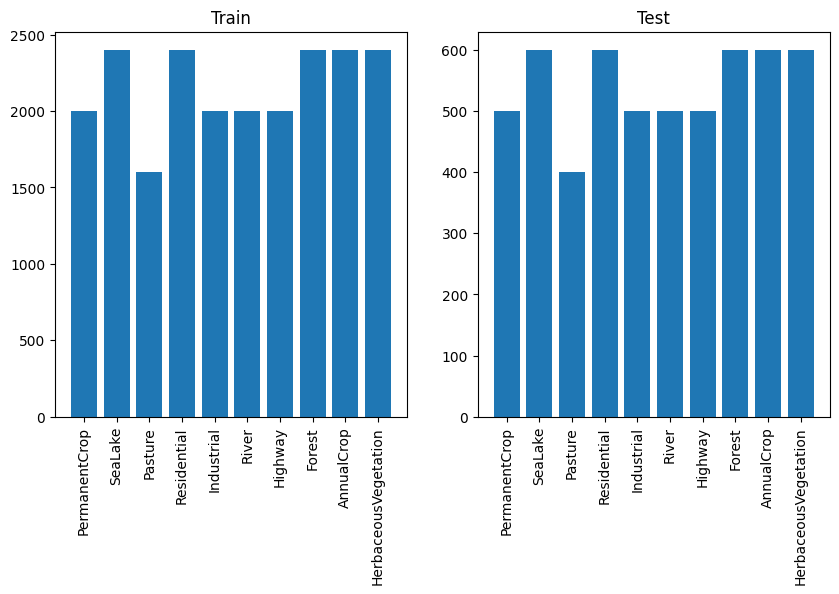

In [6]:
data_dir = "./data/eurosat/2750/"

train_df = pd.DataFrame(columns=["image", "label"])
test_df = pd.DataFrame(columns=["image", "label"])
classes = os.listdir(data_dir)
class_to_idx = {classes[i]: i for i in range(len(classes))} # Class ==> index dictonary
idx_to_class = {class_to_idx[i]: i for i in class_to_idx.keys()} # Index ==> Class dictonary

for cls in classes:
    images = [
        os.path.join(data_dir, cls, i) for i in os.listdir(os.path.join(data_dir, cls))
    ]
    labels = [class_to_idx[cls]] * len(images)
    df = pd.DataFrame({"image": images, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)
    train_df = pd.concat([train_df, df.iloc[: int(0.8 * len(df))]], ignore_index=True)
    test_df = pd.concat([test_df, df.iloc[int(0.8 * len(df)) :]], ignore_index=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.bar(classes, [len(train_df[train_df["label"] == class_to_idx[i]]) for i in classes])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title("Test")
plt.bar(classes, [len(test_df[test_df["label"] == class_to_idx[i]]) for i in classes])
plt.xticks(rotation=90)
plt.show()

In [7]:
class EuroSAT_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image']
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[idx]['label']
        
        return img, label

In [8]:
normalise_means = [0.4914, 0.4822, 0.4465]
normalise_stds = [0.2023, 0.1994, 0.2010]

train_transform = Transforms.Compose([Transforms.RandomHorizontalFlip(),
    Transforms.ToTensor(),
    Transforms.Normalize(normalise_means, normalise_stds),])

test_transforms = Transforms.Compose([Transforms.ToTensor(), Transforms.Normalize(normalise_means, normalise_stds)])

train_dataset = EuroSAT_Dataset(train_df, train_transform)
test_dataset = EuroSAT_Dataset(test_df, test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [9]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expantion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expantion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expantion)

        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x+= identity
        x = self.relu(x)
        return x
    
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


    def _make_layer(self,block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride!= 1 or self.in_channels!= out_channels*4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                                                 nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels) )
        return nn.Sequential(*layers)
    

In [10]:
def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes).to(device)

def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(Block, [3, 4, 23, 3], img_channels, num_classes).to(device)

def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(Block, [3, 4, 36, 3], img_channels, num_classes).to(device)

In [11]:
model = ResNet50(num_classes=NUM_CLASSES)

In [12]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, testloader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
        
    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0
        
        print(f"Epoch: {i + 1}")
        
        for images, targets in tqdm(trainloader, desc= "Train\t"):
            
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)

        scheduler.step()
        
        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in tqdm(testloader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_test_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_test_loss / len(testloader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), './models/model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")

    return train_losses, train_acc, test_losses, test_acc

In [13]:
# optimizer and loss and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.001)

In [14]:
train_losses, train_acc, test_losses, test_acc = train(model, NUM_EPOCHS, optimizer, criterion, scheduler, device, train_loader, test_loader)
print("  Finished Training  ")

Epoch: 1


Train	:   0%|          | 0/675 [00:00<?, ?it/s]

Test	: 100%|██████████| 338/338 [00:03<00:00, 103.37it/s]


Train Loss: 1.733, Train Acc: 0.416, Test Loss: 1.328, Test Acc: 0.555

Epoch: 2


Test	: 100%|██████████| 338/338 [00:03<00:00, 111.24it/s]


Train Loss: 0.999, Train Acc: 0.640, Test Loss: 1.011, Test Acc: 0.644

Epoch: 3


Test	: 100%|██████████| 338/338 [00:03<00:00, 104.15it/s]


Train Loss: 0.792, Train Acc: 0.713, Test Loss: 0.872, Test Acc: 0.702

Epoch: 4


Test	: 100%|██████████| 338/338 [00:03<00:00, 107.02it/s]


Train Loss: 0.706, Train Acc: 0.747, Test Loss: 0.877, Test Acc: 0.699

Epoch: 5


Test	: 100%|██████████| 338/338 [00:03<00:00, 109.62it/s]


Train Loss: 0.634, Train Acc: 0.778, Test Loss: 0.865, Test Acc: 0.704

Epoch: 6


Test	: 100%|██████████| 338/338 [00:03<00:00, 104.93it/s]


Train Loss: 0.551, Train Acc: 0.807, Test Loss: 0.720, Test Acc: 0.762

Epoch: 7


Test	: 100%|██████████| 338/338 [00:03<00:00, 106.45it/s]


Train Loss: 0.479, Train Acc: 0.835, Test Loss: 0.606, Test Acc: 0.803

Epoch: 8


Test	: 100%|██████████| 338/338 [00:03<00:00, 109.83it/s]


Train Loss: 0.424, Train Acc: 0.851, Test Loss: 0.551, Test Acc: 0.814

Epoch: 9


Test	: 100%|██████████| 338/338 [00:03<00:00, 105.27it/s]


Train Loss: 0.372, Train Acc: 0.869, Test Loss: 0.525, Test Acc: 0.827

Epoch: 10


Test	: 100%|██████████| 338/338 [00:03<00:00, 108.35it/s]


Train Loss: 0.450, Train Acc: 0.848, Test Loss: 0.583, Test Acc: 0.809

Epoch: 11


Test	: 100%|██████████| 338/338 [00:03<00:00, 109.89it/s]


Train Loss: 0.361, Train Acc: 0.876, Test Loss: 0.475, Test Acc: 0.839

Epoch: 12


Test	: 100%|██████████| 338/338 [00:03<00:00, 101.92it/s]


Train Loss: 0.314, Train Acc: 0.891, Test Loss: 0.384, Test Acc: 0.869

Epoch: 13


Test	: 100%|██████████| 338/338 [00:03<00:00, 109.28it/s]


Train Loss: 0.270, Train Acc: 0.905, Test Loss: 0.413, Test Acc: 0.855

Epoch: 14


Test	: 100%|██████████| 338/338 [00:03<00:00, 106.52it/s]


Train Loss: 0.239, Train Acc: 0.917, Test Loss: 0.366, Test Acc: 0.878

Epoch: 15


Test	: 100%|██████████| 338/338 [00:03<00:00, 108.40it/s]


Train Loss: 0.208, Train Acc: 0.928, Test Loss: 0.373, Test Acc: 0.878

Epoch: 16


Test	: 100%|██████████| 338/338 [00:02<00:00, 113.50it/s]


Train Loss: 0.186, Train Acc: 0.936, Test Loss: 0.346, Test Acc: 0.884

Epoch: 17


Test	: 100%|██████████| 338/338 [00:03<00:00, 106.76it/s]


Train Loss: 0.157, Train Acc: 0.945, Test Loss: 0.328, Test Acc: 0.891

Epoch: 18


Test	: 100%|██████████| 338/338 [00:03<00:00, 106.66it/s]


Train Loss: 0.134, Train Acc: 0.954, Test Loss: 0.318, Test Acc: 0.893

Epoch: 19


Test	: 100%|██████████| 338/338 [00:03<00:00, 110.27it/s]


Train Loss: 0.118, Train Acc: 0.959, Test Loss: 0.300, Test Acc: 0.902

Epoch: 20


Test	: 100%|██████████| 338/338 [00:03<00:00, 111.08it/s]


Train Loss: 0.104, Train Acc: 0.964, Test Loss: 0.275, Test Acc: 0.907

  Finished Training  


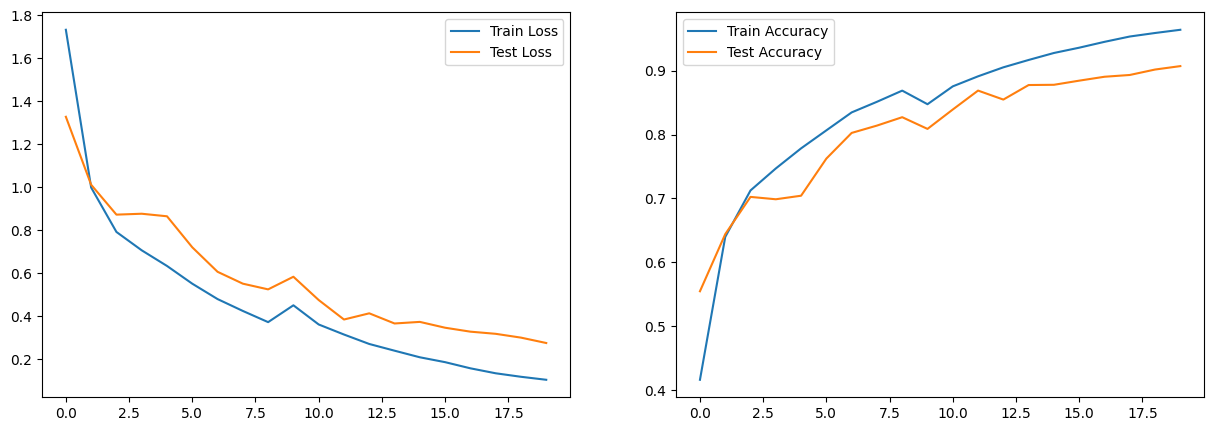

In [15]:
def plot_graphs(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Test Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Test Accuracy")
    plt.legend()
    plt.show()

plot_graphs(train_losses, train_acc, test_losses, test_acc)